In [1]:
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
from torchvision import datasets, transforms
# import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0., 0., 0.), (255, 255, 255))])
# Download and load the training data
trainset = datasets.CIFAR100('../datasets/CiFAR100/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# # Download and load the test data
# testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ../datasets/CiFAR100/cifar-100-python.tar.gz to ../datasets/CiFAR100/


In [3]:
import numpy as np

In [4]:
classes = np.unique(trainset.targets)
classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [5]:
# Creating Mapping for source and payload images

mapping = {key: key + 1 for key in np.arange(0, len(classes), 2)}
mapping

{0: 1,
 2: 3,
 4: 5,
 6: 7,
 8: 9,
 10: 11,
 12: 13,
 14: 15,
 16: 17,
 18: 19,
 20: 21,
 22: 23,
 24: 25,
 26: 27,
 28: 29,
 30: 31,
 32: 33,
 34: 35,
 36: 37,
 38: 39,
 40: 41,
 42: 43,
 44: 45,
 46: 47,
 48: 49,
 50: 51,
 52: 53,
 54: 55,
 56: 57,
 58: 59,
 60: 61,
 62: 63,
 64: 65,
 66: 67,
 68: 69,
 70: 71,
 72: 73,
 74: 75,
 76: 77,
 78: 79,
 80: 81,
 82: 83,
 84: 85,
 86: 87,
 88: 89,
 90: 91,
 92: 93,
 94: 95,
 96: 97,
 98: 99}

In [6]:
# Converting tensors to numpy

train_x = trainset.data
train_y = np.array(trainset.targets)

In [7]:
# Creating source and payload masks from labels

source_mask = np.in1d(train_y, list(mapping.keys()))
payload_mask = np.logical_not(source_mask)

print(np.sum(source_mask), np.sum(payload_mask))

# Creating source and payload data
source_data, source_labels = train_x[source_mask], train_y[source_mask]
payload_data, payload_labels = train_x[payload_mask], train_y[payload_mask]

25000 25000


In [8]:
from PIL import Image

In [9]:
payload_data = np.array([np.array(Image.fromarray(img).convert('L')) for img in payload_data])

In [10]:
source_data = source_data / 255.
payload_data = payload_data / 255.

# Visualizing Data

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


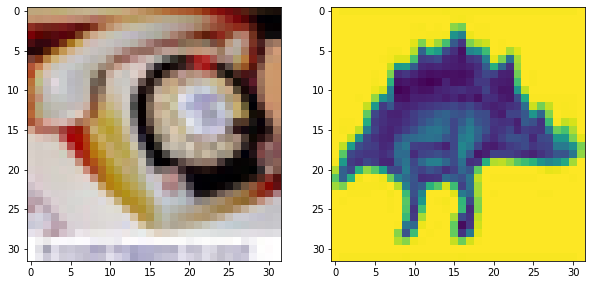

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(source_data[1])
plt.subplot(1,2,2)
plt.imshow(payload_data[1])

# Train Val Test splitting

In [13]:
split_size = 0.8

total_data = source_data.shape[0]

train_size = int(total_data * split_size)
source_train = source_data[:train_size] # , source_labels[:train_size]
payload_train = payload_data[:train_size] # , payload_labels[:train_size]

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:]
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

source_train
payload_train

(20000, 32, 32, 3) (2500, 32, 32, 3) (2500, 32, 32, 3)
(20000, 32, 32) (2500, 32, 32) (2500, 32, 32)


array([[[1.        , 1.        , 1.        , ..., 0.78823529,
         0.85490196, 0.73333333],
        [1.        , 0.99607843, 0.99607843, ..., 0.67058824,
         0.63529412, 0.57647059],
        [1.        , 0.99607843, 1.        , ..., 0.75686275,
         0.6627451 , 0.48627451],
        ...,
        [0.63529412, 0.61176471, 0.60392157, ..., 0.0745098 ,
         0.22745098, 0.2745098 ],
        [0.53333333, 0.52156863, 0.54901961, ..., 0.0627451 ,
         0.39607843, 0.57647059],
        [0.4       , 0.4       , 0.45098039, ..., 0.1254902 ,
         0.45490196, 0.59607843]],

       [[1.        , 0.99215686, 0.99215686, ..., 0.99215686,
         0.99215686, 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1. 

# Declaring Architecture


In [71]:
class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        
    def define_encoder(self):
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
#         self.encoder_bn2 = nn.BatchNorm2d(32)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(131, 64, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn4 = nn.BatchNorm2d(32)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(198, 128, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn6 = nn.BatchNorm2d(32)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(262, 128, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(64, 32, kernel_size=3, padding=1)

#         self.encoder_bn8 = nn.BatchNorm2d(32)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(32, 16, kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(16, 8, kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(8, 3, kernel_size=1)
        
    
    def define_decoder(self):
        
        self.decoder_layers1 = nn.Conv2d(3, 256, kernel_size=3, padding=1)
        self.decoder_layers2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
#         self.decoder_bn2 = nn.BatchNorm2d(64)
        
        self.decoder_layers3 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_layers4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
#         self.decoder_bn4 = nn.BatchNorm2d(32)
        
        self.decoder_layers5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        self.decoder_payload3 = nn.Conv2d(19, 8, kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_payload5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        
        # source_decoder
        self.decoder_source1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        
        self.decoder_source3 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        
        self.decoder_source5 = nn.Conv2d(8, 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    
    def forward(self, s, p):
        
        s = s.reshape((-1, 3, 32, 32))
        p = p.reshape((-1, 1, 32, 32))
        
        k = s
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1) # 64
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
#         s = self.encoder_bn2(s)
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((k, s, p, s1), 1) # 128
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
#         s = self.encoder_bn4(s)
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((k,s),1)
        s3 = torch.cat((s3, p, s2), 1) # 192
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
#         s = self.encoder_bn6(s)
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
#         s = self.encoder_bn8(s)
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.reshape(-1, 3, 32, 32)

        k=d
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
#         d = self.decoder_bn2(d)
        
        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
#         d = self.decoder_bn4(d)
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        d2 = torch.cat((k,d),1)
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d2))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
   
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return encoder_output, decoded_payload, decoded_source
    

model = StegNet()
model

StegNet(
  (encoder_payload_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_21): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(131, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_41): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source

In [72]:
model = model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

metric = nn.L1Loss()

In [73]:
#model.load_state_dict(torch.load('model_cifar_modified_original.pt'))

# Training

In [74]:
epochs = 10000

train_losses, val_losses = [], []
batch_size = 64
test_batch_size = 50

flat_source_size = 32 * 32 * 3
flat_payload_size = 32 * 32
# valid_loss_min = +np.inf

for epoch in range(epochs):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(1):
        s, p = source_train[idx*batch_size: (idx * batch_size) + batch_size], payload_train[idx*batch_size: (idx * batch_size) + batch_size]
        s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()

        optimizer.zero_grad()

        s=s.cuda()
        p=p.cuda()
        
        e_out, dp_out, ds_out = model.forward(s,p)
        
        e_loss = criterion(e_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
        dp_loss = criterion(dp_out.reshape((-1, flat_payload_size)), p.reshape((-1, flat_payload_size)))
        ds_loss = criterion(ds_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
        loss = e_loss + dp_loss + ds_loss
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print("Train loss: ", train_loss / 64)     

Streaming output truncated to the last 5000 lines.
Train loss:  0.00015956962306518108
Train loss:  0.0001686556643107906
Train loss:  0.0001618840469745919
Train loss:  0.00015849900955799967
Train loss:  0.00015888574125710875
Train loss:  0.0001498658093623817
Train loss:  0.0001558919029776007
Train loss:  0.0001478670455981046
Train loss:  0.00015396987146232277
Train loss:  0.0001529055880382657
Train loss:  0.000150896463310346
Train loss:  0.00014539650874212384
Train loss:  0.00014152121730148792
Train loss:  0.00014233381079975516
Train loss:  0.000140388889121823
Train loss:  0.0001447018003091216
Train loss:  0.00014157698024064302
Train loss:  0.00014250638196244836
Train loss:  0.00014129368355497718
Train loss:  0.0001372839033138007
Train loss:  0.00013864110223948956
Train loss:  0.00013486867828760296
Train loss:  0.00013594003394246101
Train loss:  0.00013613092596642673
Train loss:  0.00013483806105796248
Train loss:  0.00013731684884987772
Train loss:  0.0001353420

In [75]:
model = model.cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)

metric = nn.L1Loss()

In [76]:
def get_loss(model, s, p):
    e_out, dp_out, ds_out = model.forward(s, p)
        
    e_loss = criterion(e_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
#     e_sum_loss = criterion(torch.div(torch.sum(e_out, dim=1).view((-1, int(flat_image_size / 3.))), 765) , torch.div(torch.sum(s, dim=-1).view((-1, int(flat_image_size / 3.))), 765))
    dp_loss = criterion(dp_out.reshape((-1, flat_payload_size)), p.reshape((-1, flat_payload_size)))
    ds_loss = criterion(ds_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
    
    loss = e_loss + dp_loss + ds_loss #+ e_sum_loss
    
    return loss

In [77]:
def train_step(model, optimizer, s, p):
    temp_loss = 0.
    optimizer.zero_grad()

    loss = get_loss(model, s, p)

    loss.backward()
    optimizer.step()
    
    temp_loss += loss.item()
    
#     optimizer.zero_grad()

#     loss = get_loss(model, p, s)

#     loss.backward()
#     optimizer.step()
#     temp_loss += loss.item()
    
    return temp_loss


In [78]:
epochs = 1

train_losses, val_losses = [], []
batch_size = 64
test_batch_size = 50

flat_source_size = 32 * 32 * 3
flat_payload_size = 32 * 32

valid_loss_min = 0.034161

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(total_batches):
        start = idx*batch_size
        end = start + batch_size
        indices1 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        indices2 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        np.random.shuffle(indices1)
        np.random.shuffle(indices2)
        
        s = source_train[indices1]
        p = payload_train[indices2]
        s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()
        train_loss += train_step(model, optimizer, s, p)
    
    else:
        val_loss = 0.
        model.eval()
        val_batches = int(len(source_val) / test_batch_size) 
        with torch.no_grad():
            for idx in range(val_batches):
                s, p = source_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size], payload_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size]
                s, p = torch.from_numpy(s).float().cuda(), torch.from_numpy(p).float().cuda()
                
                e_out, dp_out, ds_out = model.forward(s, p)

                e_loss = metric(e_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
                dp_loss = metric(dp_out.reshape((-1, flat_payload_size)), p.reshape((-1, flat_payload_size)))
                ds_loss = metric(ds_out.reshape((-1, flat_source_size)), s.reshape((-1, flat_source_size)))
                loss = e_loss + dp_loss + ds_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / (total_batches * 2))
            val_losses.append(val_loss / val_batches)
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
        scheduler.step()
        if val_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_losses[-1]))
            torch.save(model.state_dict(), 'model_cifar_modified_original.pt')
            valid_loss_min = val_losses[-1]

                

100%|██████████| 1/1 [01:19<00:00, 79.10s/it]

Epoch: 0
Train Loss: 0.012595199972403031, Val Loss: 0.13197195529937744


In [79]:
import skimage

In [80]:
with torch.no_grad():
    model.eval()
    e, dp, ds = model.forward(s, p)

In [81]:
e, dp, ds = e.cpu(), dp.cpu(), ds.cpu()
ss, pp = s.cpu(), p.cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


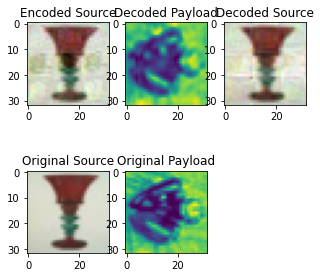

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


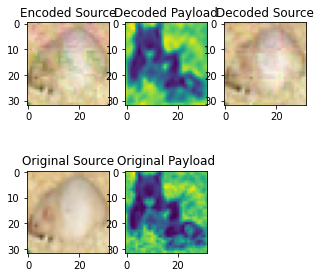

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


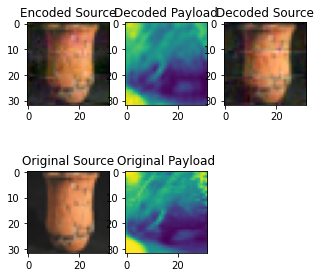

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


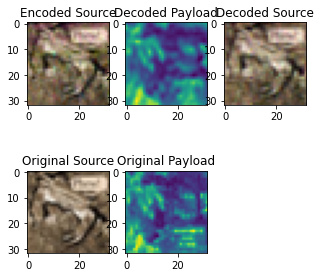

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


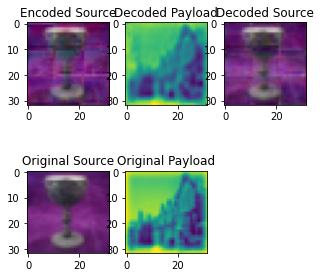

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


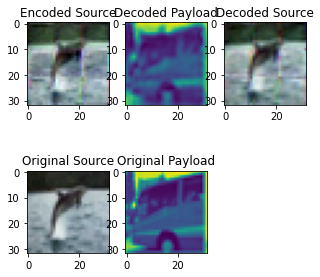

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


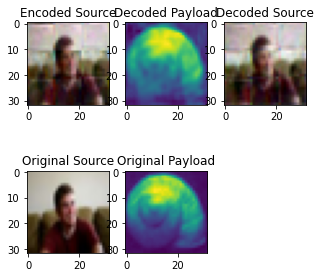

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


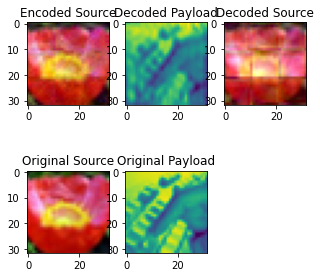

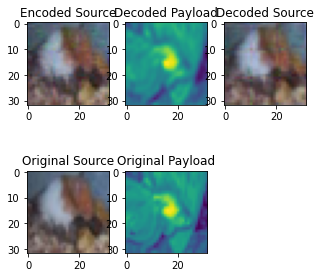

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


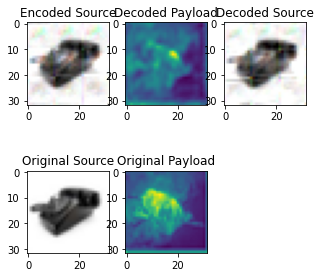

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


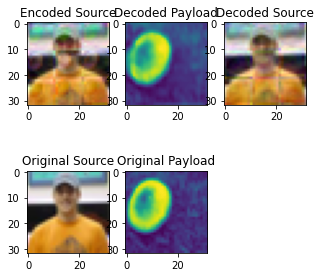

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


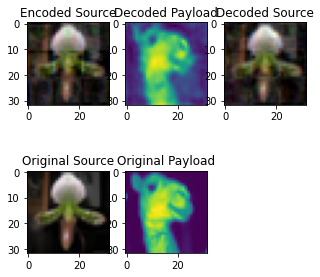

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


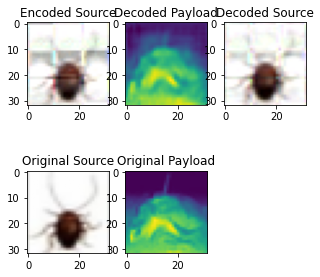

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


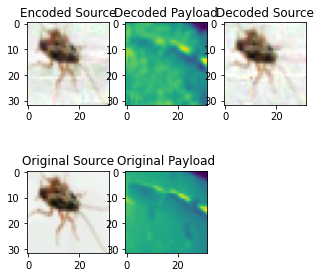

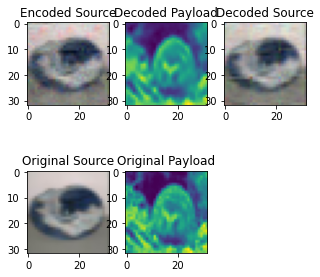

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


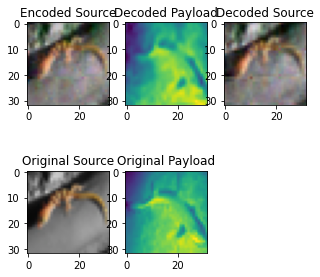

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


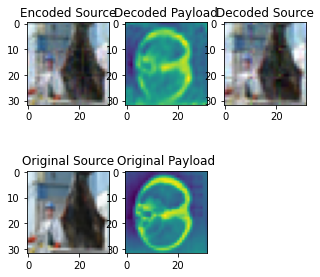

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


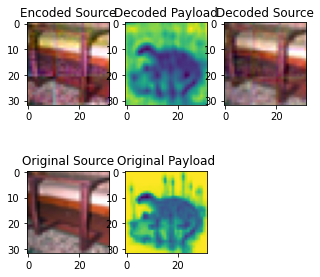

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


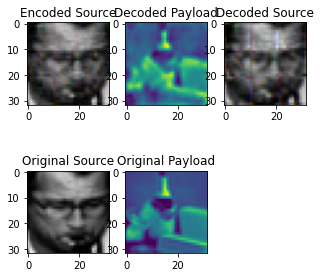

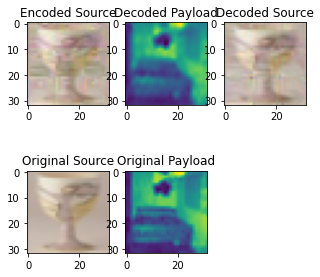

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


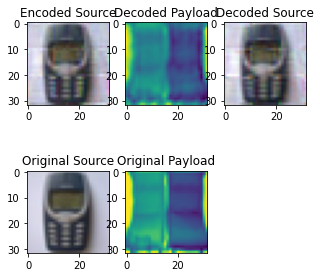

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


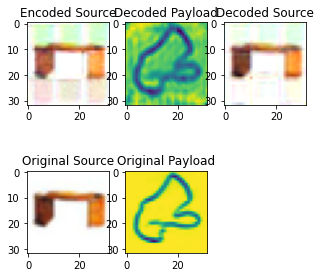

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


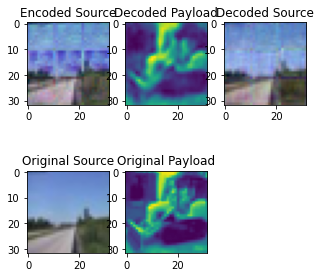

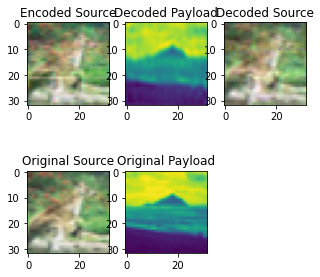

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


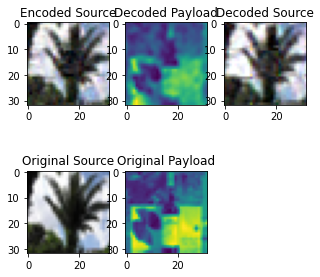

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


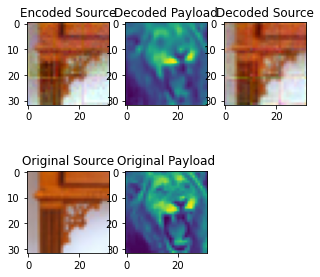

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


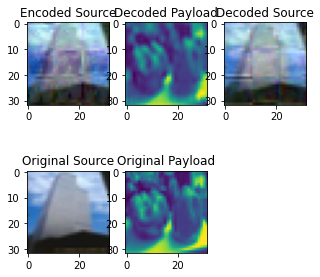

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


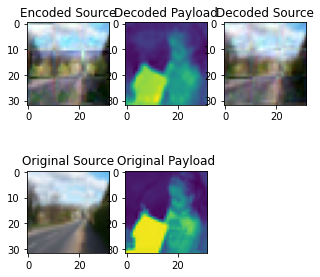

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


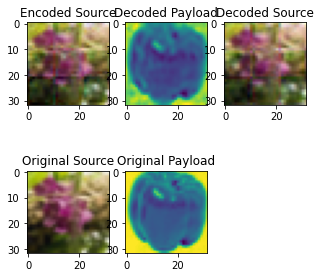

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


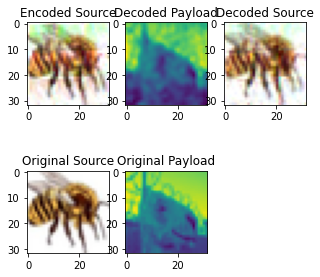

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


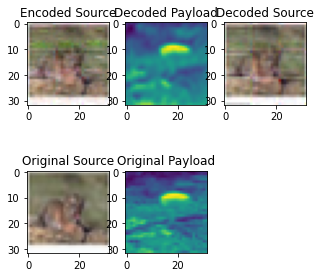

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


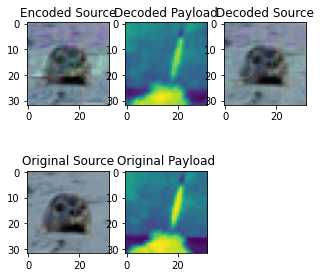

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


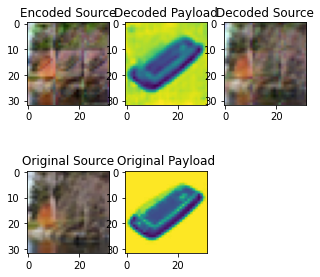

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


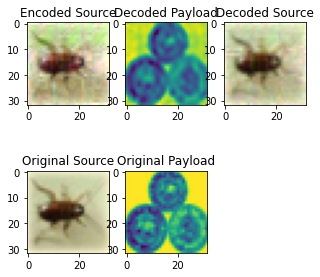

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


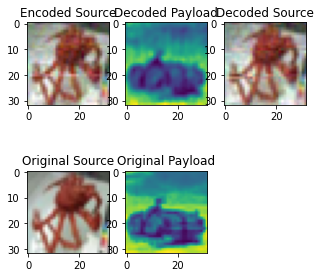

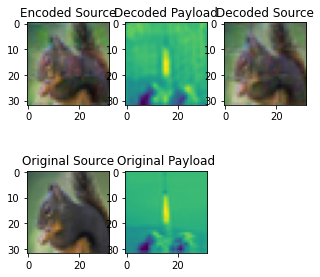

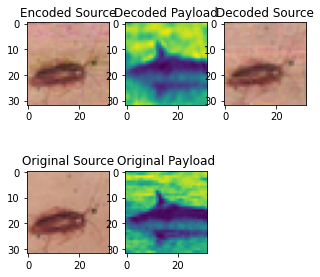

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


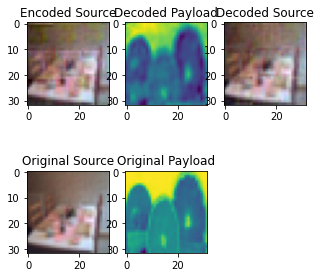

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


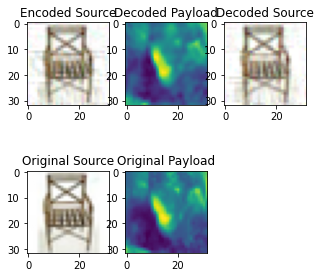

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


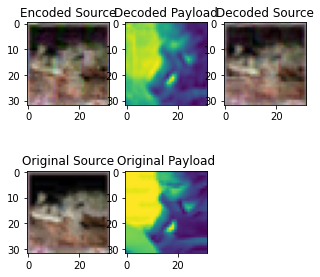

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


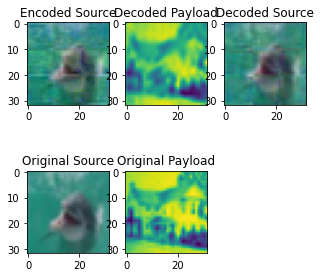

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


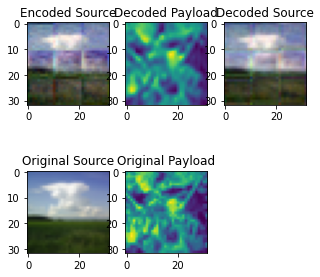

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


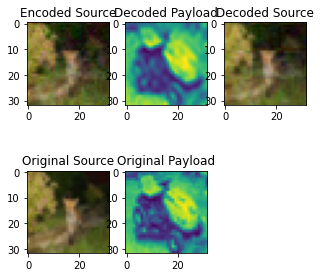

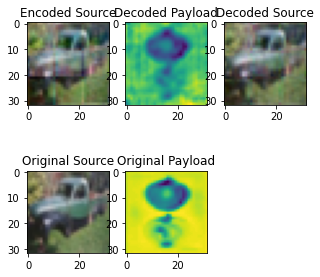

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


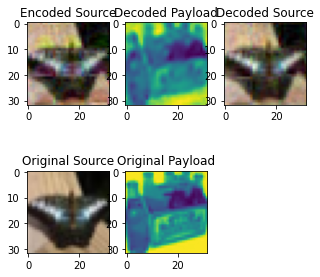

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


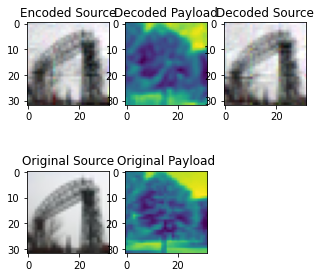

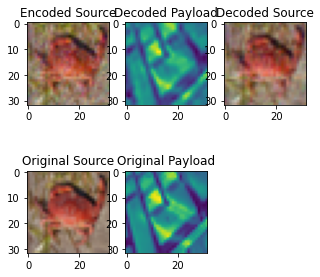

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


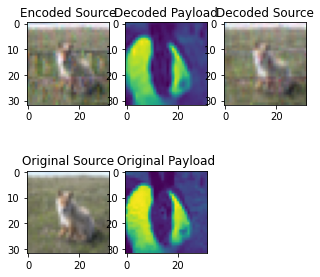

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


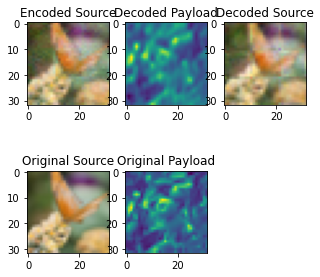

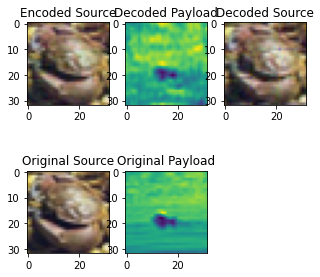

In [82]:
from skimage import metrics
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

index = 20
encoded_psnr = []
decoded_psnr = []
for index in range(len(e)):
    eimage = e.view((-1, 32, 32, 3)).numpy()[index]
    dpimage = dp.view((-1, 32, 32)).numpy()[index]
    dsimage = ds.view((-1, 32, 32, 3)).numpy()[index]

    sourceimage, payloadimage = ss.numpy()[index], pp.numpy()[index]
    plt.figure(figsize=(5,5))
    plt.subplot(2, 3, 1)
    plt.title('Encoded Source')
    plt.imshow(eimage)
    plt.subplot(2, 3, 2)
    plt.title('Decoded Payload')
    plt.imshow(dpimage)
    plt.subplot(2, 3, 3)
    plt.title('Decoded Source')
    plt.imshow(dsimage)

    plt.subplot(2, 3, 4)
    plt.title('Original Source')
    plt.imshow(sourceimage)
    plt.subplot(2, 3, 5)
    plt.title('Original Payload')
    plt.imshow(payloadimage)
    
    plt.show()

    sourceimage = rgb2gray(sourceimage)
    payloadimage = rgb2gray(payloadimage)
    eimage = rgb2gray(eimage)
    dpimage = rgb2gray(dpimage)

    e_psnr, d_psnr = metrics.structural_similarity(sourceimage, eimage,full=True), metrics.structural_similarity(payloadimage, dpimage, full=True)
    encoded_psnr.append(e_psnr)
    decoded_psnr.append(d_psnr)

In [83]:
np.mean(np.mean(encoded_psnr))

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


0.878588938348423

In [84]:
np.mean(np.mean(decoded_psnr))

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


0.8890237584309014

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
torch.save(model.state_dict(), "/content/drive/MyDrive/DL/modeltriple.pt")

In [87]:
model.load_state_dict(torch.load('/content/drive/MyDrive/DL/modeltriple.pt'))

<All keys matched successfully>

In [61]:
np.sum(eimage, axis=-1)

array([14.2339115, 15.363838 , 15.828086 , 14.31645  , 16.68788  ,
       16.421144 , 14.067587 , 14.873108 , 16.886574 , 17.321548 ,
       16.886272 , 13.945665 , 16.140814 , 15.44229  , 14.724163 ,
       14.428255 , 12.820751 , 10.852213 , 11.571801 , 12.1294365,
       12.085358 , 10.378221 , 13.208209 , 15.91304  , 15.0748005,
       12.105061 , 10.51     ,  9.464988 ,  8.508144 ,  8.353157 ,
        9.688639 ,  9.669003 ], dtype=float32)

In [ ]:
s.shape

torch.Size([64, 32, 32, 3])

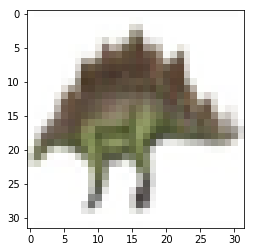

In [ ]:
plt.imshow(train_x[1].reshape((3,32,32)).reshape((32,32,3)))